In [1]:
import autosklearn.classification
import os
import numpy as np
import matplotlib.pyplot as plt
import filtering
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import xgboost
import time
import sklearn

def read_data(experiment_num):
    dataset_path = '/home/user/Desktop/Demonstration/handForceSensing/src/Experiments/' + str(experiment_num) + '/hists_tips_filt.npy'
    hist = np.load(dataset_path)
    hist_features = hist.reshape(hist.shape[0], -1)
    print("Read histogram features with shape", hist_features.shape)
    
    path = '../src/Experiments/' + str(experiment_num) + '/'
    image_files = sorted(os.listdir(path+'1processed'))
    data_nb = hist_features.shape[0]
    values = np.zeros((data_nb,2))
    value = np.zeros(2)
    for i in range(1,data_nb):
        value[0] = int(int(image_files[i][-8:-4]))
        value[1] = int(int(image_files[i][-13:-9]))
        values[i] = value
    print("Read values (from png labels) with shape", values.shape)
    
    # filter loaded values
    filt = filtering.ButterLowpasssFilter()
    values = filt.filter(values)
    print("Filtered loaded values")
    return values, hist_features
    
def stack(hist_features, values):
    # stack histograms and values
    hist_window_stack = window_stack(hist_features, width=15)
    hist_windowed = np.average(hist_window_stack, axis=1)
    values_window_stack =  window_stack(values, width=15)
    values_windowed = np.average(values_window_stack, axis=1)
    print("Stacked histograms with shape", hist_windowed.shape, "and values with shape", values_windowed.shape)
    return hist_windowed, values_windowed

def window_stack(a, stepsize=1, width=3):
    length = len(a)
    indexer = np.arange(width)[None, :] + stepsize*np.arange((length-width+1)//stepsize)[:, None]
    return a[indexer]

def filter_data(values, hist_features, values_windowed):
    # Filter requirements.
    order = 1
    fs = 30.0       # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz
    
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)
    
    data = values
    data_show = values_windowed

    n = len(data)
    T = n/fs

    t = np.linspace(0, T, n, endpoint=False)

    # Filter the data, and plot both the original and filtered signals.
    hist_filtered = butter_lowpass_filter(hist_features, cutoff, fs, order)
    values_filtered = butter_lowpass_filter(values, cutoff, fs, order)
    
    return hist_filtered, values_filtered, t
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    dim_nb = len(data.shape) 
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

def split_data(values_filtered, hist_filtered):
    data = hist_filtered
    labels = values_filtered.sum(axis=1)

    split_test = np.zeros(labels.shape, dtype='bool')

    split_test[:] = False
    split_train = np.logical_not(split_test)

    x_train = data[split_train]
    y_train = labels[split_train]

    x_test = data[split_test]
    y_test = labels[split_test]

    print("Splited data for ML, shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

def train_regressor(x_train, y_train):
    regr = xgboost.XGBRegressor(n_estimators=100,
                                min_child_weight=25,
                                max_depth=15,
                                learning_rate=0.08, 
                                gamma=0,
                                subsample=0.75,
                                colsample_bytree=1)
    t0 = time.time()
    regr.fit(x_train, y_train)
    print("Regressor trained; t =", time.time() - t0)
    return regr

def predict(regr, data):
    t0 = time.time()
    preds = regr.predict(data) / 2.0
    print("Prediction; t =", time.time() - t0)
    return preds

def filter_prediction(preds):
    # Filter requirements.
    order = 1
    fs = 30.0       # sample rate, Hz
    cutoff = .3  # desired cutoff frequency of the filter, Hz

    hist_filtered = butter_lowpass_filter(preds, cutoff, fs, order)
    return hist_filtered

def plot_predictions(t, preds, values_filtered):
    plt.figure(figsize=(20,15))
    plt.plot(t, preds, 'g-', linewidth=2, label='prediction')
    plt.plot(t, values_filtered.mean(axis=1), 'r-', linewidth=2, label='ground truth')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()
    plt.xlabel('Time [sec]')
    plt.subplots_adjust(hspace=0.35)
    plt.show()

In [2]:
values1, hist_features1 = read_data(6)
hist_windowed1, values_windowed1 = stack(hist_features1, values1)
hist_filtered1, values_filtered1, t1 = filter_data(values1, hist_features1, values_windowed1)
x_train1, y_train1, x_test1, y_test1 = split_data(values_filtered1, hist_features1)

Read histogram features with shape (15046, 100)
Read values (from png labels) with shape (15046, 2)
Filtered loaded values
Stacked histograms with shape (15032, 100) and values with shape (15032, 2)
Splited data for ML, shapes: (15046, 100) (15046,) (0, 100) (0,)


In [3]:
values2, hist_features2 = read_data(7)
hist_windowed2, values_windowed2 = stack(hist_features2, values2)
hist_filtered2, values_filtered2, t2 = filter_data(values2, hist_features2, values_windowed2)
x_train2, y_train2, x_test2, y_test2 = split_data(values_filtered2, hist_features2)

Read histogram features with shape (3010, 100)
Read values (from png labels) with shape (3010, 2)
Filtered loaded values
Stacked histograms with shape (2996, 100) and values with shape (2996, 2)
Splited data for ML, shapes: (3010, 100) (3010,) (0, 100) (0,)


Regressor trained; t = 29.516582250595093
Prediction; t = 0.021355390548706055
R2 score 0.211197742234
MSE score 244197.401855


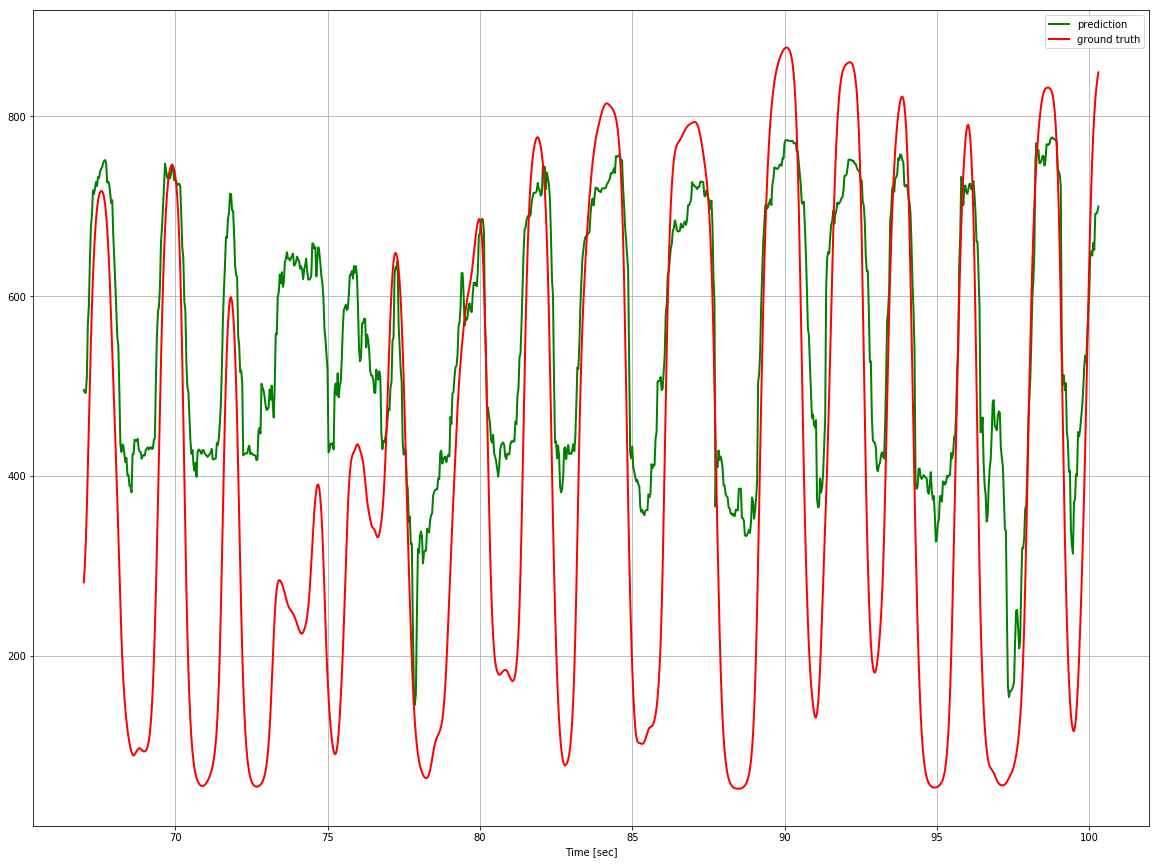

In [4]:
regr = train_regressor(x_train1, y_train1)
predictions2 = predict(regr, hist_filtered2)
predictions2_filtered = filter_prediction(predictions2)
print("R2 score", sklearn.metrics.r2_score(y_train2, predictions2))
print("MSE score", sklearn.metrics.mean_squared_error(y_train2, predictions2))
plot_predictions(t2[-1000:], predictions2[-1000:], values_filtered2[-1000:])

Prediction; t = 0.19392156600952148


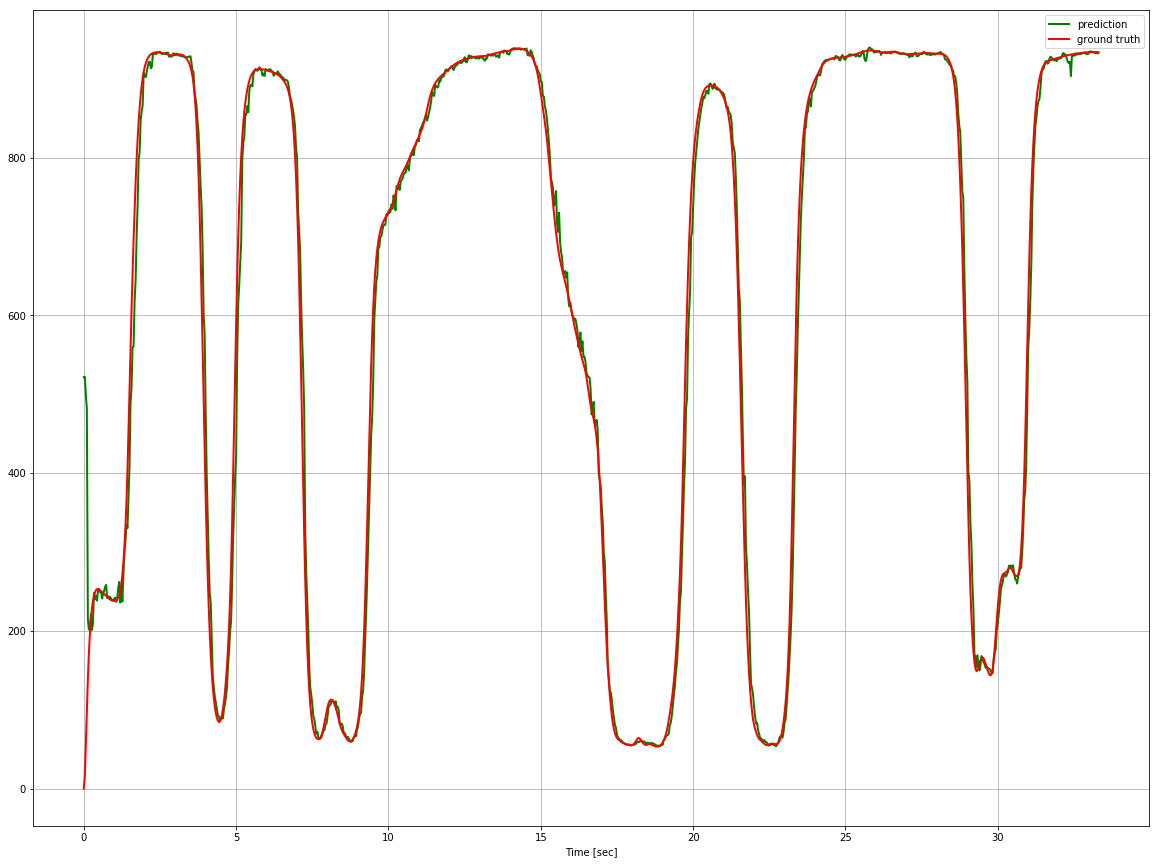

In [5]:
predictions1 = predict(regr, hist_filtered1)
predictions1_filtered = filter_prediction(predictions1)
plot_predictions(t1[:1000], predictions1[:1000], values_filtered1[:1000])

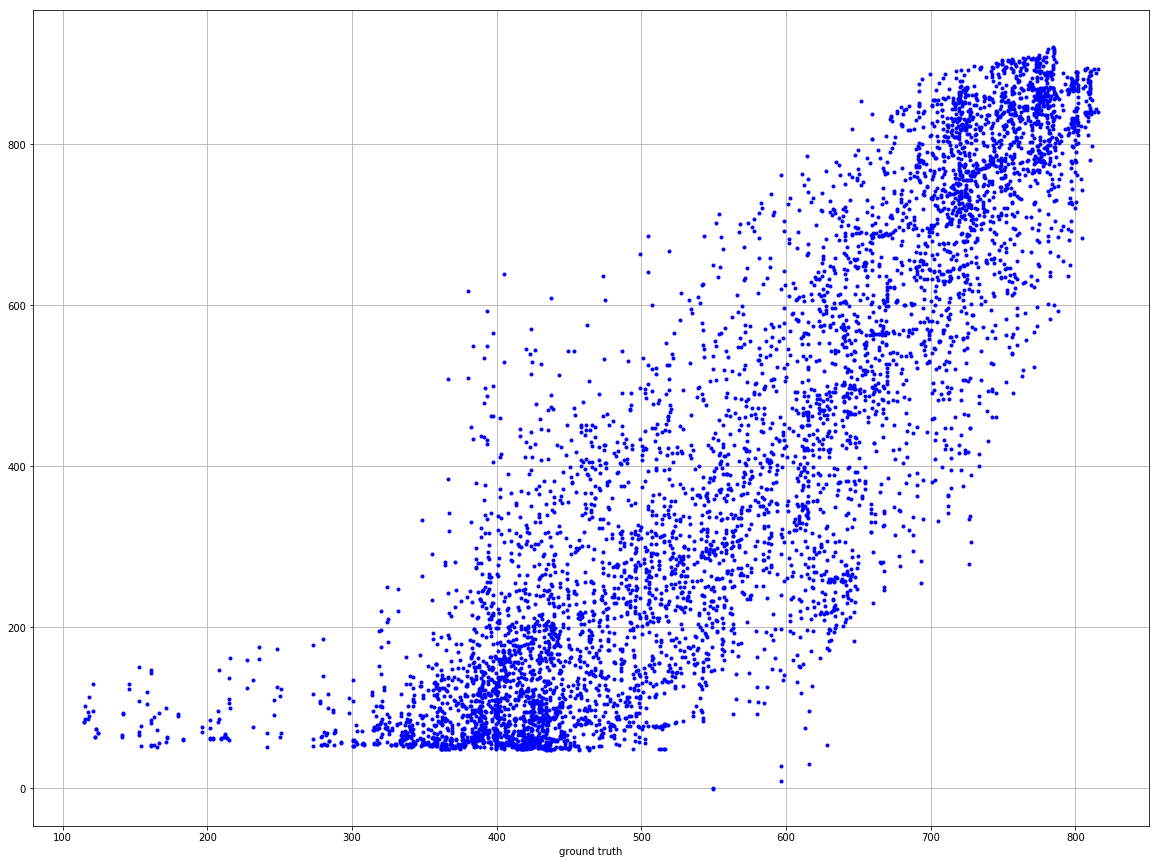

In [7]:
plt.figure(figsize=(20,15))
plt.plot(predictions2, values_filtered2, 'b.', linewidth=2)
plt.xlabel('prediction')
plt.grid()
plt.xlabel('ground truth')
plt.subplots_adjust(hspace=0.35)
plt.show()

In [80]:
import autosklearn.classification
import os
import numpy as np
import matplotlib.pyplot as plt

dataset_path = '/home/user/Desktop/Demonstration/handForceSensing/src/Experiments/3//hists_tips_filt.npy'

hist = np.load(dataset_path)

hist_features = hist.reshape(hist.shape[0], -1)

print(hist_features.shape)

(3007, 60)


In [45]:
np.save('tip_predictions_3.npy', predictions)

In [9]:
import pickle
with open('../models/alina/hand_tip.pkl', 'wb') as fio:
    pickle.dump(regr, fio)

In [280]:
with open('../models/First/hand_tip_test.pkl', 'rb') as fio:
    a = pickle.load(fio)

<h2> Load model and make predictions</h2>

<h3>Specify filter params</h3>

In [1]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    dim_nb = len(data.shape) 
    
    b, a = butter_lowpass(cutoff, fs, order=order)

    y = lfilter(b, a, data, axis=0)
    return y


# Filter requirements.
order = 1
fs = 30.0       # sample rate, Hz
cutoff = 3  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
# Filter the data, and plot both the original and filtered signals.
# hist_filtered = butter_lowpass_filter(hist_features, cutoff, fs, order)
# values_filtered = butter_lowpass_filter(values, cutoff, fs, order)

def filter_data(data):
    return butter_lowpass_filter(data, cutoff, fs, order)

<h3>Load and stack histograms</h3>

In [2]:
import numpy as np

dataset_paths = ['tip_hist_5.npy',
                 'tip_hist_3.npy',                
                ]

histograms = np.empty((0,60))

for dataset_path in dataset_paths:
    hist = np.load(dataset_path)

    hist_features = hist.reshape(hist.shape[0], -1)
    
    hist_filtered = filter_data(hist_features)
    
    histograms = np.vstack((histograms, hist_filtered))

print('histograms.shape', histograms.shape)


histograms.shape (11990, 60)


<h3>Load and stack values</h3>

In [3]:
import os

paths = ['dataset/black_back_new/5',
         'dataset/black_back_new/3'     
        ]

values = np.empty((0,2))

for path in paths:
    
    image_files = sorted(os.listdir(path))
    
    data_nb = len(image_files)

    values_tmp = np.zeros((data_nb,2))

    value = np.zeros(2)

    for i in range(0,data_nb):

        value[0] = int(int(image_files[i][-8:-4]))
        value[1] = int(int(image_files[i][-13:-9]))

        values_tmp[i] = value
        
    values_tmp_filtered = filter_data(values_tmp)
        
    values = np.vstack((values, values_tmp_filtered))

print('values.shape', values.shape)

values.shape (11990, 2)


<h3>Time params for plots</h3>

In [4]:
n = len(values)
T = n/fs

t = np.linspace(0, T, n, endpoint=False)

<h3>Load model and refit</h3>

In [75]:
data = histograms
labels = values.sum(axis=1)

print ('dataset shape:', data.shape)

NameError: name 'histograms' is not defined

In [6]:
import pickle
import time

import multiprocessing
import shutil

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

from autosklearn.metrics import accuracy, mean_squared_error, r2
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.constants import *

start_time = time.time()

with open('hand_tip_test.pkl', 'rb') as f:
    automl = pickle.load(f)

end_time = time.time()
    
print ('model loaded in', end_time-start_time, ' seconds.')

model loaded in 0.1613469123840332  seconds.


In [7]:
split_test = np.zeros(labels.shape, dtype='bool')

split_test[2000:3500] = True
split_test[8500:10000] = True
# split_test[8000:] = True
# split_test[10995:] = True
split_train = np.logical_not(split_test)

x_train = data[split_train]
y_train = labels[split_train]

x_test = data[split_test]
y_test = labels[split_test]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(8990, 60) (8990,) (3000, 60) (3000,)


In [8]:
a=np.asarray_chkfinite(x_train)

if a.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(a).all():
    print ('wtf')

In [9]:
start_time = time.time()

automl.refit(x_train.astype('float32'), y_train.astype('float32'))

end_time = time.time()

print('refit done in', end_time-start_time, 'seconds.')

refit done in 35.349661350250244 seconds.


In [10]:
predictions = automl.predict(x_test)
print("R2 score", sklearn.metrics.r2_score(y_test, predictions))
print("MSE score", sklearn.metrics.mean_squared_error(y_test, predictions))

R2 score 0.865341415125667
MSE score 60606.10473712166


In [137]:
start_time = time.time()
    
predictions = automl.predict(data)

end_time = time.time()

print('predictions done in', end_time-start_time, 'seconds.')

predictions done in 0.4173412322998047 seconds.


In [138]:
np.save('tip_predictions_5+3.npy', predictions)

In [21]:
predictions = np.load('predictions_5.npy')

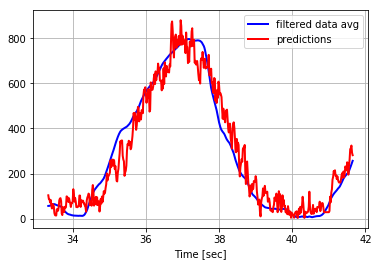

In [144]:
values_avg = values.mean(axis=1)
predictions_show = predictions/2.0

start_index = 2000
stop_index = 2500

plt.figure(figsize=(6,4))

# plt.plot(t[200:400], of_labels_filtered[200:400, 0], 'g-', linewidth=2, label='filtered data 0')
# plt.plot(t[200:400], of_labels_filtered[200:400, 1], 'r-', linewidth=2, label='filtered data 1')
plt.plot(t[start_index:stop_index], values_avg[start_index:stop_index], 'b-', linewidth=2, label='filtered data avg')
plt.plot(t[start_index:stop_index], predictions_show[start_index:stop_index], 'r-', linewidth=2, label='predictions')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.xlabel('Time [sec]')

plt.savefig('dif.png')

plt.subplots_adjust(hspace=0.35)
plt.show()

In [145]:
cumsum_labels = np.cumsum(of_labels_filtered_avg)
cumsum_predictions = np.cumsum(predictions_show)

plt.figure(figsize=(5,4))

plt.plot(t[start_index:stop_index], cumsum_labels[start_index:stop_index], 'b-', linewidth=2, label='filtered data avg')
plt.plot(t[start_index:stop_index], cumsum_predictions[start_index:stop_index], 'r-', linewidth=2, label='predictions')

plt.grid()
plt.legend()

plt.xlabel('Time [sec]')

plt.savefig('cumsum.png')
plt.show()

NameError: name 'of_labels_filtered_avg' is not defined

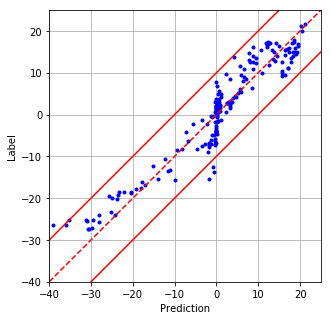

In [17]:
cumsum_labels = np.cumsum(of_labels_filtered_avg)
cumsum_predictions = np.cumsum(predictions_show)

plt.figure(figsize=(5,5))

plt.plot(of_labels_filtered_avg[start_index:stop_index], predictions_show[start_index:stop_index], 'b.')
plt.plot([-40, 40], [-40, 40], 'r--')
plt.plot([-50, 40], [-40, 50], 'r-')
plt.plot([-30, 40], [-40, 30], 'r-')
plt.grid()

plt.xlabel('Prediction')
plt.ylabel('Label')

plt.xlim(-40, 25)
plt.ylim(-40, 25)
plt.gca().set_aspect('equal', adjustable='box')

# plt.subplots_adjust(hspace=0.35)
plt.savefig('comp_plot.png')
plt.show()